# Neural Networks for solving regression problem: Hyperparameter tuning using RandomizedSearchCV
Author: Akhil Raj

This notebook is for turning each hyperparameter using cross-validation in a deep learning model, And thus finding the best hyperparameter values.

Methodology:-

A default model is defined as base model. For each hyperparamter, values is varied and the model is trained. 5-fold cross-validation is used with RandomizedSearchCV to find best performing set of values.


## 1. Importing Libraries
Tensorflow and Keras is used to build deep neural networks for solving the regression problem. Scikit-learn is used for data pre-processing, train-test split and evaluating the performance of the model. Matplotlib is used for plotting the graphs.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import preprocessing
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from keras.wrappers.scikit_learn import KerasRegressor 

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Activation, Dropout, Input

## 2. Loading data

Loading data using pandas and using standard scaling on the data.

In [19]:
df = pd.read_csv('clean_kcHouse.csv')

In [20]:
df_main= df.copy()
df_main.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,age,reno_age,reno_flag
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1340,5650,59,59,0
1,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,2720,8062,82,82,0
2,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1360,5000,49,49,0
3,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1800,7503,28,28,0
4,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,2238,6819,19,19,0


A detailed exploratory data analysis was performed on the data. Please refer EDA_kcHouse notebook to learn more about the insights on data and feature selection.

Here, the Target variable **Price** is an economic variable. To represent Vertical changes in prices related to various attributes, Logarithmic scale is used. Reference: https://www.visualizingeconomics.com/blog/2016/8/5/real-growth-in-us-housing-prices-log-scale 

So converting the price to log scale.

The model predictions can be converted to normal range by taking the exponential of predicted values.

Train-Test split is 80-20.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_main[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                                                       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                                                       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age',
                                                       'reno_age', 'reno_flag']],   
                                                    df_main[['price']].apply(np.log),   
                                                    test_size = 0.2,
                                                    random_state = 0)

In [22]:
# Create the Scaler object
std_scaler = preprocessing.StandardScaler()

# apply the transformation to the training data
x_train_std = std_scaler.fit_transform(x_train) 

# apply the transformation to the testing data
x_test_std = std_scaler.transform(x_test) # but we only transform our testing data with already fit scaler

# convert resulting array back to dataframe
x_test_std_df = pd.DataFrame(x_test_std, columns = x_train.columns)

x_test_std_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,age,reno_age,reno_flag
0,-1.559642,-0.429099,-0.967696,-0.284067,-0.890471,-0.011425,-0.24467,2.487529,-0.537157,-0.647077,-0.653487,-0.194373,-0.301564,1.674382,1.677821,-0.067254
1,-0.386408,1.753886,1.087562,-0.283810,0.963170,-0.011425,3.46569,-0.635179,1.429489,0.575127,1.011825,0.186617,-0.143362,-0.668136,-0.666793,-0.067254
2,-0.386408,-0.429099,-0.672929,-0.760557,0.963170,-0.011425,-0.24467,-0.635179,0.446166,-1.054479,0.648018,-0.760889,-0.714850,-1.472284,-1.471660,-0.067254
3,0.786826,-0.065268,0.614312,-0.087352,-0.890471,-0.011425,-0.24467,-0.635179,-0.537157,-0.618981,2.292834,0.501348,-0.347404,0.485641,0.488017,-0.067254
4,-0.386408,0.662394,0.425012,-0.449411,0.963170,-0.011425,-0.24467,-0.635179,-0.537157,0.799900,-0.653487,0.733256,-0.542254,-0.947840,-0.946747,-0.067254


## 3. Defining Functions and Base model
A base model is defined as the base model with name : **model**

In [23]:
def get_optimizer(optimizer,lr):
    """
    Map and initialise optimizers with learning rate
    
    """
    if optimizer == 'adadelta':
        opt = tf.keras.optimizers.Adadelta(learning_rate=lr)
    elif optimizer == 'adagrad':
        opt = tf.keras.optimizers.Adagrad(learning_rate=lr)
    elif optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'adamax':
        opt = tf.keras.optimizers.Adamax(learning_rate=lr)
    elif optimizer == 'ftrl':
        opt = tf.keras.optimizers.Ftrl(learning_rate=lr)
    elif optimizer == 'nadam':
        opt = tf.keras.optimizers.Nadam(learning_rate=lr)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=lr)
    return opt

In [24]:
def base_model(learning_rate=0.1,activation_fn='relu',no_layers=1,no_neurons=32,loss='huber',optimizer='ftrl'):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    model = Sequential()
    model.add(Dense(16,activation=activation_fn))
    for _ in range(no_layers):
        model.add(Dense(no_neurons,activation=activation_fn))
    model.add(Dense(1, activation = activation_fn))
    opt = get_optimizer(optimizer,learning_rate)
    model.compile(optimizer=opt,loss=loss,metrics = [tf.keras.metrics.RootMeanSquaredError()])
    # print(model.summary())
    return model

In [25]:
tf.keras.backend.clear_session()
# Create a KerasRegressor
model = KerasRegressor(build_fn = base_model,
                       verbose = 0, epochs=40, 
                       batch_size = 48)

## 4.1 Number of Hidden Layers

In [26]:
tf.keras.backend.clear_session()
params_1={'no_layers':[1,2,3,4]}

random_search_1 = RandomizedSearchCV(model,
                                   param_distributions = params_1,
                                   cv = KFold(5),verbose=5, scoring='r2')
random_search_results_1 = random_search_1.fit(x_train_std, y_train)

print("Best Score: ",
      random_search_results_1.best_score_,
      "and Best Params: ",
      random_search_results_1.best_params_)

nh = random_search_results_1.best_params_

y_test_1= random_search_results_1.predict(x_test_std)
print('MAE:', metrics.mean_absolute_error(y_test_1, y_test))  
print('MSE:', metrics.mean_squared_error(y_test_1, y_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_1, y_test)))
print('R2:',metrics.r2_score(y_test_1, y_test))

C:\Users\Akhil\.conda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .......................no_layers=1;, score=0.602 total time=   6.0s
[CV 2/5] END .......................no_layers=1;, score=0.597 total time=   5.8s
[CV 3/5] END .......................no_layers=1;, score=0.609 total time=   5.8s
[CV 4/5] END .......................no_layers=1;, score=0.601 total time=   6.0s
[CV 5/5] END .......................no_layers=1;, score=0.590 total time=   6.3s
[CV 1/5] END .......................no_layers=2;, score=0.632 total time=   6.5s
[CV 2/5] END .......................no_layers=2;, score=0.626 total time=   6.4s
[CV 3/5] END .......................no_layers=2;, score=0.635 total time=   6.2s


In [ ]:
nh

{'no_layers': 2}

## 4.2 Number of nodes

In [ ]:
tf.keras.backend.clear_session()
params_2={'no_layers':[nh['no_layers']],'no_neurons':[24,32,40,48]}

random_search_2 = RandomizedSearchCV(model,
                                   param_distributions = params_2,
                                   cv = KFold(5),verbose=5, scoring='r2')
random_search_results_2 = random_search_2.fit(x_train_std, y_train)

print("Best Score: ",
      random_search_results_2.best_score_,
      "and Best Params: ",
      random_search_results_2.best_params_)

nn = random_search_results_2.best_params_

y_test_2= random_search_results_2.predict(x_test_std)
print('MAE:', metrics.mean_absolute_error(y_test_2, y_test))  
print('MSE:', metrics.mean_squared_error(y_test_2, y_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_2, y_test)))
print('R2:',metrics.r2_score(y_test_2, y_test))

C:\Users\Akhil\.conda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ........no_layers=2, no_neurons=24;, score=0.627 total time=   6.4s
[CV 2/5] END ........no_layers=2, no_neurons=24;, score=0.624 total time=   7.0s
[CV 3/5] END ........no_layers=2, no_neurons=24;, score=0.629 total time=   6.5s
[CV 4/5] END ........no_layers=2, no_neurons=24;, score=0.620 total time=   6.5s
[CV 5/5] END ........no_layers=2, no_neurons=24;, score=0.610 total time=   6.6s
[CV 1/5] END ........no_layers=2, no_neurons=32;, score=0.632 total time=   6.6s
[CV 2/5] END ........no_layers=2, no_neurons=32;, score=0.626 total time=   6.7s
[CV 3/5] END ........no_layers=2, no_neurons=32;, score=0.635 total time=   6.9s
[CV 4/5] END ........no_layers=2, no_neurons=32;, score=0.611 total time=   6.5s
[CV 5/5] END ........no_layers=2, no_neurons=32;, score=0.620 total time=   6.6s
[CV 1/5] END ........no_layers=2, no_neurons=40;, score=0.628 total time=   6.9s
[CV 2/5] END ........no_layers=2, no_neurons=40;,

In [ ]:
nn

{'no_neurons': 40, 'no_layers': 2}

## 4.3 Optimizers

In [ ]:
tf.keras.backend.clear_session()
params_3={'no_layers':[nh['no_layers']],'no_neurons':[nn['no_neurons']],'optimizer':['sgd','adadelta','adagrad','adam','adamax','ftrl','nadam','rmsprop']}

random_search_3 = RandomizedSearchCV(model,
                                   param_distributions = params_3,
                                   cv = KFold(5),verbose=5, scoring='r2')
random_search_results_3 = random_search_3.fit(x_train_std, y_train)

print("Best Score: ",
      random_search_results_3.best_score_,
      "and Best Params: ",
      random_search_results_3.best_params_)

op = random_search_results_3.best_params_

y_test_3= random_search_results_3.predict(x_test_std)
print('MAE:', metrics.mean_absolute_error(y_test_3, y_test))  
print('MSE:', metrics.mean_squared_error(y_test_3, y_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_3, y_test)))
print('R2:',metrics.r2_score(y_test_3, y_test))

C:\Users\Akhil\.conda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END no_layers=2, no_neurons=40, optimizer=sgd;, score=0.579 total time=   6.0s
[CV 2/5] END no_layers=2, no_neurons=40, optimizer=sgd;, score=0.613 total time=   5.8s
[CV 3/5] END no_layers=2, no_neurons=40, optimizer=sgd;, score=0.351 total time=   5.8s
[CV 4/5] END no_layers=2, no_neurons=40, optimizer=sgd;, score=0.383 total time=   6.1s
[CV 5/5] END no_layers=2, no_neurons=40, optimizer=sgd;, score=0.462 total time=   6.3s
[CV 1/5] END no_layers=2, no_neurons=40, optimizer=adadelta;, score=0.593 total time=   6.7s
[CV 2/5] END no_layers=2, no_neurons=40, optimizer=adadelta;, score=0.567 total time=   6.8s
[CV 3/5] END no_layers=2, no_neurons=40, optimizer=adadelta;, score=0.605 total time=   6.5s
[CV 4/5] END no_layers=2, no_neurons=40, optimizer=adadelta;, score=-0.074 total time=   6.8s
[CV 5/5] END no_layers=2, no_neurons=40, optimizer=adadelta;, score=-0.063 total time=   7.0s
[CV 1/5] END no_layers=2, no_neur

In [ ]:
op

{'optimizer': 'ftrl', 'no_neurons': 40, 'no_layers': 2}

## 4.4 Learning Rate

In [ ]:
tf.keras.backend.clear_session()
params_4={'no_layers':[nh['no_layers']],'no_neurons':[nn['no_neurons']],'optimizer':[op['optimizer']],'learning_rate':[0.001,0.01,0.1]}

random_search_4 = RandomizedSearchCV(model,
                                   param_distributions = params_4,
                                   cv = KFold(5),verbose=5, scoring='r2')
random_search_results_4 = random_search_4.fit(x_train_std, y_train)

print("Best Score: ",
      random_search_results_4.best_score_,
      "and Best Params: ",
      random_search_results_4.best_params_)

lr = random_search_results_4.best_params_

y_test_4= random_search_results_4.predict(x_test_std)
print('MAE:', metrics.mean_absolute_error(y_test_4, y_test))  
print('MSE:', metrics.mean_squared_error(y_test_4, y_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_4, y_test)))
print('R2:',metrics.r2_score(y_test_4, y_test))

C:\Users\Akhil\.conda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END learning_rate=0.001, no_layers=2, no_neurons=40, optimizer=ftrl;, score=-24.478 total time=   7.0s
[CV 2/5] END learning_rate=0.001, no_layers=2, no_neurons=40, optimizer=ftrl;, score=-22.563 total time=   6.7s
[CV 3/5] END learning_rate=0.001, no_layers=2, no_neurons=40, optimizer=ftrl;, score=-23.126 total time=   6.6s
[CV 4/5] END learning_rate=0.001, no_layers=2, no_neurons=40, optimizer=ftrl;, score=-23.298 total time=   6.7s
[CV 5/5] END learning_rate=0.001, no_layers=2, no_neurons=40, optimizer=ftrl;, score=-26.024 total time=   6.8s
[CV 1/5] END learning_rate=0.01, no_layers=2, no_neurons=40, optimizer=ftrl;, score=0.599 total time=   7.1s
[CV 2/5] END learning_rate=0.01, no_layers=2, no_neurons=40, optimizer=ftrl;, score=0.589 total time=   6.7s
[CV 3/5] END learning_rate=0.01, no_layers=2, no_neurons=40, optimizer=ftrl;, score=0.612 total time=   6.7s
[CV 4/5] END learning_rate=0.01, no_layers=2, no_neur

In [ ]:
lr

{'optimizer': 'ftrl', 'no_neurons': 40, 'no_layers': 2, 'learning_rate': 0.1}


## 4.5 Activation functions

In [ ]:
tf.keras.backend.clear_session()
params_5={'no_layers':[nh['no_layers']],
            'no_neurons':[nn['no_neurons']],
            'optimizer':[op['optimizer']],
            'learning_rate':[lr['learning_rate']],
            'activation_fn':['relu','sigmoid','softmax','softplus','softsign','tanh','selu','elu']}

random_search_5 = RandomizedSearchCV(model,
                                   param_distributions = params_5,
                                   cv = KFold(5),verbose=5, scoring='r2')
random_search_results_5 = random_search_5.fit(x_train_std, y_train)

print("Best Score: ",
      random_search_results_5.best_score_,
      "and Best Params: ",
      random_search_results_5.best_params_)

af = random_search_results_5.best_params_

y_test_5= random_search_results_5.predict(x_test_std)
print('MAE:', metrics.mean_absolute_error(y_test_5, y_test))  
print('MSE:', metrics.mean_squared_error(y_test_5, y_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_5, y_test)))
print('R2:',metrics.r2_score(y_test_5, y_test))

C:\Users\Akhil\.conda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END activation_fn=relu, learning_rate=0.1, no_layers=2, no_neurons=40, optimizer=ftrl;, score=0.628 total time=   6.7s
[CV 2/5] END activation_fn=relu, learning_rate=0.1, no_layers=2, no_neurons=40, optimizer=ftrl;, score=0.627 total time=   6.7s
[CV 3/5] END activation_fn=relu, learning_rate=0.1, no_layers=2, no_neurons=40, optimizer=ftrl;, score=0.638 total time=   6.8s
[CV 4/5] END activation_fn=relu, learning_rate=0.1, no_layers=2, no_neurons=40, optimizer=ftrl;, score=0.615 total time=   6.7s
[CV 5/5] END activation_fn=relu, learning_rate=0.1, no_layers=2, no_neurons=40, optimizer=ftrl;, score=0.618 total time=   7.0s
[CV 1/5] END activation_fn=sigmoid, learning_rate=0.1, no_layers=2, no_neurons=40, optimizer=ftrl;, score=-681.678 total time=   6.6s
[CV 2/5] END activation_fn=sigmoid, learning_rate=0.1, no_layers=2, no_neurons=40, optimizer=ftrl;, score=-687.295 total time=   6.6s
[CV 3/5] END activation_fn=sigmo

KeyboardInterrupt: 

In [ ]:
af

{'optimizer': 'ftrl',
 'no_neurons': 16,
 'no_layers': 2,
 'learning_rate': 0.1,
 'activation_fn': 'relu'}

## 4.6 Loss Function

In [ ]:
tf.keras.backend.clear_session()
params_6={'no_layers':[nh['no_layers']],
            'no_neurons':[nn['no_neurons']],
            'optimizer':[op['optimizer']],
            'learning_rate':[lr['learning_rate']],
            'activation_fn':[af['activation_fn']],
            'loss':['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error','mean_squared_logarithmic_error','log_cosh','huber']}

random_search_6 = RandomizedSearchCV(model,
                                   param_distributions = params_6,
                                   cv = KFold(5),verbose=5, scoring='r2')
random_search_results_6 = random_search_6.fit(x_train_std, y_train)

print("Best Score: ",
      random_search_results_6.best_score_,
      "and Best Params: ",
      random_search_results_6.best_params_)

lo = random_search_results_6.best_params_

y_test_6= random_search_results_6.predict(x_test_std)
print('MAE:', metrics.mean_absolute_error(y_test_6, y_test))  
print('MSE:', metrics.mean_squared_error(y_test_6, y_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_6, y_test)))
print('R2:',metrics.r2_score(y_test_6, y_test))

C:\Users\Akhil\.conda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END activation_fn=relu, learning_rate=0.1, loss=mean_squared_error, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.566 total time=   6.7s
[CV 2/5] END activation_fn=relu, learning_rate=0.1, loss=mean_squared_error, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.533 total time=   6.7s
[CV 3/5] END activation_fn=relu, learning_rate=0.1, loss=mean_squared_error, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.558 total time=   6.7s
[CV 4/5] END activation_fn=relu, learning_rate=0.1, loss=mean_squared_error, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.566 total time=   7.9s
[CV 5/5] END activation_fn=relu, learning_rate=0.1, loss=mean_squared_error, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.583 total time=   7.4s
[CV 1/5] END activation_fn=relu, learning_rate=0.1, loss=mean_absolute_error, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.573 total time=   6.8s
[CV 2/5] END activati

In [ ]:
lo

{'optimizer': 'ftrl',
 'no_neurons': 16,
 'no_layers': 2,
 'loss': 'huber',
 'learning_rate': 0.1,
 'activation_fn': 'relu'}

## 4.7 Batch Size 

In [ ]:
tf.keras.backend.clear_session()
params_7={'no_layers':[nh['no_layers']],
            'no_neurons':[nn['no_neurons']],
            'optimizer':[op['optimizer']],
            'learning_rate':[lr['learning_rate']],
            'activation_fn':[af['activation_fn']],
            'loss':[lo['loss']],
            'batch_size':[16,32,64]}


random_search_7 = RandomizedSearchCV(model,
                                   param_distributions = params_7,
                                   cv = KFold(5),verbose=5, scoring='r2')
random_search_results_7 = random_search_7.fit(x_train_std, y_train)

print("Best Score: ",
      random_search_results_7.best_score_,
      "and Best Params: ",
      random_search_results_7.best_params_)

bs = random_search_results_7.best_params_

y_test_7= random_search_results_7.predict(x_test_std)
print('MAE:', metrics.mean_absolute_error(y_test_7, y_test))  
print('MSE:', metrics.mean_squared_error(y_test_7, y_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_7, y_test)))
print('R2:',metrics.r2_score(y_test_7, y_test))

C:\Users\Akhil\.conda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END activation_fn=relu, batch_size=16, learning_rate=0.1, loss=huber, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.574 total time=  17.5s
[CV 2/5] END activation_fn=relu, batch_size=16, learning_rate=0.1, loss=huber, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.529 total time=  18.5s
[CV 3/5] END activation_fn=relu, batch_size=16, learning_rate=0.1, loss=huber, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.605 total time=  17.4s
[CV 4/5] END activation_fn=relu, batch_size=16, learning_rate=0.1, loss=huber, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.614 total time=  17.1s
[CV 5/5] END activation_fn=relu, batch_size=16, learning_rate=0.1, loss=huber, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.617 total time=  17.8s
[CV 1/5] END activation_fn=relu, batch_size=32, learning_rate=0.1, loss=huber, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.552 total time=   8.9s
[CV 2/5] E

In [ ]:
bs

{'optimizer': 'ftrl',
 'no_neurons': 16,
 'no_layers': 2,
 'loss': 'huber',
 'learning_rate': 0.1,
 'batch_size': 64,
 'activation_fn': 'relu'}

## 4.8 Epochs

In [ ]:
tf.keras.backend.clear_session()
params_8={'no_layers':[nh['no_layers']],
            'no_neurons':[nn['no_neurons']],
            'optimizer':[op['optimizer']],
            'learning_rate':[lr['learning_rate']],
            'activation_fn':[af['activation_fn']],
            'loss':[lo['loss']],
            'batch_size':[bs['batch_size']], 
            'epochs':[10,20,30,40]}

random_search_8 = RandomizedSearchCV(model,
                                   param_distributions = params_8,
                                   cv = KFold(5),verbose=5, scoring='r2')
random_search_results_8 = random_search_8.fit(x_train_std, y_train)

print("Best Score: ",
      random_search_results_8.best_score_,
      "and Best Params: ",
      random_search_results_8.best_params_)

ep = random_search_results_8.best_params_

y_test_8= random_search_results_8.predict(x_test_std)
print('MAE:', metrics.mean_absolute_error(y_test_8, y_test))  
print('MSE:', metrics.mean_squared_error(y_test_8, y_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_8, y_test)))
print('R2:',metrics.r2_score(y_test_8, y_test))

C:\Users\Akhil\.conda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END activation_fn=relu, batch_size=64, epochs=10, learning_rate=0.1, loss=huber, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.613 total time=   1.5s
[CV 2/5] END activation_fn=relu, batch_size=64, epochs=10, learning_rate=0.1, loss=huber, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.616 total time=   2.0s
[CV 3/5] END activation_fn=relu, batch_size=64, epochs=10, learning_rate=0.1, loss=huber, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.620 total time=   1.6s
[CV 4/5] END activation_fn=relu, batch_size=64, epochs=10, learning_rate=0.1, loss=huber, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.616 total time=   1.6s
[CV 5/5] END activation_fn=relu, batch_size=64, epochs=10, learning_rate=0.1, loss=huber, no_layers=2, no_neurons=16, optimizer=ftrl;, score=0.581 total time=   1.6s
[CV 1/5] END activation_fn=relu, batch_size=64, epochs=20, learning_rate=0.1, loss=huber, no_layers=2, no_neur

In [ ]:
ep

{'optimizer': 'ftrl',
 'no_neurons': 16,
 'no_layers': 2,
 'loss': 'huber',
 'learning_rate': 0.1,
 'epochs': 40,
 'batch_size': 64,
 'activation_fn': 'relu'}

# 5.Final Model
We train the final model with the best hyperparameters obtained.

In [ ]:
def new_model(learning_rate=ep['learning_rate'],activation_fn=ep['activation_fn'],no_layers=ep['no_layers'],no_neurons=ep['no_neurons'],loss=ep['loss'],optimizer=ep['optimizer']):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    model = Sequential()
    model.add(Dense(16,activation=activation_fn))
    for _ in range(no_layers):
        model.add(Dense(no_neurons,activation=activation_fn))
    model.add(Dense(1, activation = activation_fn))
    opt = get_optimizer(optimizer,learning_rate)
    model.compile(optimizer=opt,loss=loss,metrics = [tf.keras.metrics.RootMeanSquaredError()])    
    # print(model.summary())
    return model

In [ ]:
# Create a KerasClassifier
model = KerasRegressor(build_fn = new_model,
                       epochs = ep['epochs'], 
                       batch_size = ep['batch_size'],
                       verbose = 0)

## 5.1 Predict using test data

MAE: 0.22304601129160614
MSE: 0.08075588454792985
RMSE: 0.2841757986668285
R2: 0.4604268588088657


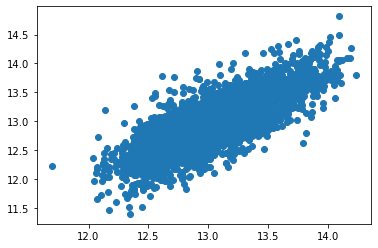

In [ ]:
model_1 = model.fit(x_train_std, y_train)
y_pred = model.predict(x_test_std)

print('MAE:', metrics.mean_absolute_error(y_pred, y_test))  
print('MSE:', metrics.mean_squared_error(y_pred, y_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_pred, y_test)))

print('R2:',metrics.r2_score(y_pred, y_test))

plt.scatter(y_pred, y_test)

The best model has a R-squared value of  48 %.
Model Hyperparameters:-

- Learning Rate: 0.1
- Number of Layers: 2
- Hidden Nodes in each layer:  [16, 16]
- optimizer: 'ftrl'
- activation: 'relu'
- loss: 'huber'
- batch size: 16
- epochs: 40